# Import data importer

In [2]:
from common.data_importer import prepro_KGData, prepro_textData
import sys

In [3]:
def print_progress(curr, full, desc='', bar_size=30):    
    bar = int((curr+1)/full*bar_size)
    sys.stdout.write(f"\r{desc}[{'='*bar}{' '*(bar_size-bar)}] {curr+1}/{full}")
    sys.stdout.flush()
    if curr+1==full: print()

In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(
    model='bart-large',
    dataset='MuP',
    # section=['abstract', 'conclusion'],
    # section=['abstract', 'introduction-1', 'conclusion'],
    section=['abstract', 'introduction-1'],
    # section=['introduction-1'],
    inputType='text',
    bs=8, 
    max_input=512,
    max_output=512,
    num_epoch=5,
    num_beams=4,
    lr=1e-5,
    fp=32,
    opt="adam",
    prototype=None
)



In [6]:
train_df, spacial_token = prepro_textData(args, "train", section=args.section, skip_null=False)

Loading section input (train)[==============================] 8379/8379
Loading summary (train)[==============================] 18934/18934


In [7]:
val_df, spacial_token = prepro_textData(args, "val", section=args.section, skip_null=False)

Loading section input (val)[==============================] 1060/1060
Loading summary (val)[==============================] 3604/3604


In [8]:
train_df['input_seq'].iloc[0]

'We study the average CVloo stability of kernel ridge-less regression and derive corresponding risk bounds. We show that the interpolating solution with minimum norm minimizes a bound on CVloo stability, which in turn is controlled by the condition number of the empirical kernel matrix. The latter can be characterized in the asymptotic regime where both the dimension and cardinality of the data go to infinity. Under the assumption of random kernel matrices, the corresponding test error should be expected to follow a double descent curve. [SEP] Organization: In section 2, we introduce basic ideas in statistical learning and empirical risk minimization, as well as the notation used in the rest of the paper. In section 3, we briefly recall some definitions of stability. In section 4, we study the stability of interpolating solutions to kernel least squares and show that the minimum norm solutions minimize an upper bound on the stability. In section 5 we discuss our results in the context 

In [9]:
train_df

,paper_id,input_seq,target_seq
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,We study the average CVloo stability of kernel...,This paper investigates kernel ridge-less regr...
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,The use of episodic memories in continual lear...,This paper presents a novel way of making full...
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,Existing Multi-Task Learning(MTL) strategies l...,This paper proposes a new framework that compu...
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This paper deals with the fuel optimization pr...,This work proposes a deep reinforcement learni...
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,Our work is concerned with the generation and ...,This paper proposes 3 deep generative models b...
...,...,...,...
18929,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,Discovering the underlying mathematical expres...,This paper presents a RNN-RL based method for ...
18930,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,Some conventional transforms such as Discrete ...,This paper proposes a new pointwise convolutio...
18931,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,Some conventional transforms such as Discrete ...,This paper presents a new pointwise convolutio...
18932,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,"Thanks to graph neural networks (GNNs), semi-s...",This paper proposes to model various uncertain...


In [5]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [6]:
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

/home/nopphawann/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [273]:
import seaborn as sns
def get_token(sentence, get_len=True):
    tokens = tokenizer.encode(
        sentence, 
        padding='max_length', 
        # max_length=args.max_input, 
        truncation=True, 
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    if get_len: return tokens.shape[1]
    else: return tokens

In [274]:
def cal_perc_tokens(df, col, perc=.95):
    tokens_df = pd.DataFrame(df[col].apply(get_token))
    return tokens_df.quantile(perc).iloc[0]

In [283]:
cal_perc_tokens(val_df, "input_seq", perc=.95)

586.0

In [21]:
train_df["input_tokens"] = train_df["input_seq"].apply(get_token)

In [41]:
import pandas as pd
input_tokens = pd.DataFrame(train_df["input_seq"].apply(get_token))


In [68]:
train_tokens = cal_perc_tokens(train_df, "input_seq", perc=.95)
val_tokens = cal_perc_tokens(val_df, "input_seq", perc=.95)
print(train_tokens)
print(val_tokens)

1035.5
1014.0


In [69]:
max_input = min(int(max(
    cal_perc_tokens(train_df, "input_seq", perc=.95),
    cal_perc_tokens(val_df, "input_seq", perc=.95)
)), 1024)
max_input

1024

In [59]:
bs=4 if max_input>950 else 8
bs

8

In [56]:
pd.concat([train_df, val_df])

,paper_id,input_seq,target_seq,input_tokens,target_tokens
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,We study the average CVloo stability of kernel...,This paper investigates kernel ridge-less regr...,207.0,75.0
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,The use of episodic memories in continual lear...,This paper presents a novel way of making full...,367.0,91.0
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,Existing Multi-Task Learning(MTL) strategies l...,This paper proposes a new framework that compu...,358.0,99.0
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This paper deals with the fuel optimization pr...,This work proposes a deep reinforcement learni...,372.0,82.0
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,Our work is concerned with the generation and ...,This paper proposes 3 deep generative models b...,342.0,105.0
...,...,...,...,...,...
3599,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,We undertake the problem of representation lea...,This paper defines a set of learnable basis fu...,NaN,NaN
3600,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,We undertake the problem of representation lea...,A typical Wavelet Transform is built through t...,NaN,NaN
3601,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,Interest has been rising lately towards method...,This paper builds a new graph convolutional ne...,NaN,NaN
3602,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,Interest has been rising lately towards method...,The authors propose using non-Euclidean spaces...,NaN,NaN


In [47]:
input_tokens.quantile(.95).iloc[0]

580.0

In [48]:
train_df["target_tokens"] = train_df["target_seq"].apply(get_token)

In [49]:
train_df

,paper_id,input_seq,target_seq,input_tokens,target_tokens
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,We study the average CVloo stability of kernel...,This paper investigates kernel ridge-less regr...,207,75
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,The use of episodic memories in continual lear...,This paper presents a novel way of making full...,367,91
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,Existing Multi-Task Learning(MTL) strategies l...,This paper proposes a new framework that compu...,358,99
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This paper deals with the fuel optimization pr...,This work proposes a deep reinforcement learni...,372,82
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,Our work is concerned with the generation and ...,This paper proposes 3 deep generative models b...,342,105
...,...,...,...,...,...
18929,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,Discovering the underlying mathematical expres...,This paper presents a RNN-RL based method for ...,287,184
18930,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,Some conventional transforms such as Discrete ...,This paper proposes a new pointwise convolutio...,333,95
18931,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,Some conventional transforms such as Discrete ...,This paper presents a new pointwise convolutio...,333,137
18932,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,"Thanks to graph neural networks (GNNs), semi-s...",This paper proposes to model various uncertain...,492,208


In [50]:
train_df.describe()

,input_tokens,target_tokens
count,18931.000000,18931.000000
mean,362.881306,133.761714
std,145.867839,75.274041
min,60.000000,29.000000
25%,275.000000,89.000000
50%,340.000000,114.000000
75%,425.000000,154.000000
max,9187.000000,1299.000000


In [52]:
list(train_df.quantile(.95))

[580.0, 266.0]

In [27]:
from scipy import stats

stats.percentileofscore(train_df['input_tokens'],1024)

99.75701230785484

[(0.0, 2048.0)]

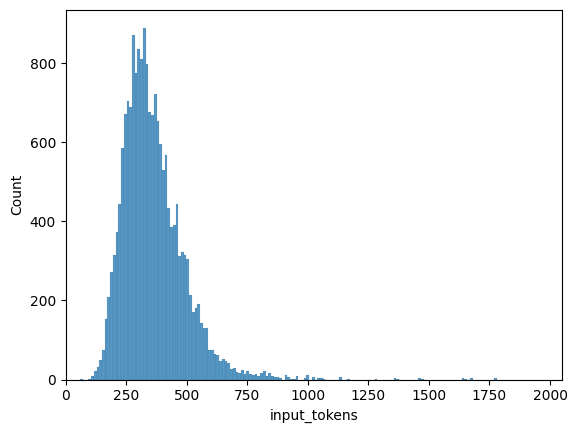

In [28]:
g = sns.histplot(train_df['input_tokens'])
g.set(xlim=(0, 1024*2))

# KG Pre-processing

In [7]:
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path

ENT_TYPES = ['Task', 'Method', 'Metric', 'Material', 'OtherScientificTerm', 'Generic']
# ENT_RANK = {
#     'Task': 5, 
#     'Method': 4, 
#     'Metric': 3, 
#     'Material': 2, 
#     'OtherScientificTerm': 2, 
#     'Generic': 1
# }
REL_TYPES = {
    'FEATURE-OF':   'Asym', 
    'PART-OF':      'Asym', 
    'USED-FOR':     'Asym', 
    'EVALUATE-FOR': 'Asym',
    'HYPONYM-OF':   'Asym', 
    'COMPARE':      'Sym',
    'CONJUNCTION':  'Sym',
}
ENT_TYPE_TOKENS = [f"[{prefix}{ent_type}]" for ent_type in ENT_TYPES for prefix in ["", "/"]]
REL_TYPE_TOKENS = [f"[{rel_type}]" for rel_type in REL_TYPES.keys()]
tokenizer.add_tokens(ENT_TYPE_TOKENS)
tokenizer.add_tokens(REL_TYPE_TOKENS)

7

In [9]:
args = Namespace(
    model='bart-large',
    dataset='arXiv',
    # dataset='MuP',
    section=['abstract'],
    # section=['abstract', 'introduction'],
    inputType='kg',
    bs=8, 
    max_input=512,
    max_output=512,
    num_epoch=5,
    num_beams=4,
    lr=1e-5,
    fp=32,
    opt="adam",
    prototype=None
)

In [10]:
def get_multifile(prepared_dir, data_split, suffix='', revised=True):
    files = sorted(os.listdir(prepared_dir))
    run_files = []
    if revised:
        for file in files:
            filename = file.split(".")[0]
            if filename[:-(2+len(suffix))]==f"revised_{data_split}_": 
                run_files.append(file)
    else:
        for file in files:
            filename = file.split(".")[0]    
            if filename[:-(2+len(suffix))]==f"{data_split}_" and filename[:-(2+len(suffix))]!=f"revised_{data_split}_": 
                run_files.append(file)
    return run_files

In [11]:
def get_KGdata(args, data_split, section):
    main_path = str((Path().absolute()).parents[0])
    data_dir = f"{main_path}/PL-Marker/_scire_models/{args.dataset}/{section}/"
    if args.dataset=='arXiv' and data_split=='train':
        run_files = get_multifile(data_dir, data_split, suffix="_re",revised=True)
    elif args.dataset=='MuP' and section in ['introduction', 'conclusion']:
        run_files = [f"revised_{data_split}_re.json"]
    else:
        run_files = [f"{data_split}_re.json"]
    json_list = []
    num_files = len(run_files)
    for i, filename in enumerate(run_files):
        with open(data_dir+filename, 'r') as json_file:
            json_list += list(json_file)
        if isinstance(args.prototype, int): 
            if len(json_list)>=args.prototype: break
    return [json.loads(json_str) for json_str in json_list]

In [12]:
skip_null = False
data_split = "val"
sections = args.section

how = 'inner' if skip_null else 'outer'
for i, sec in enumerate(sections):
    sec_df = pd.DataFrame(get_KGdata(args, data_split, sec))
    sec_df.drop(["ner", "relations"], axis=1, inplace=True)
    sec_df.rename(columns={
        "sentences": f"{sec}_sent",
        "predicted_ner": f"{sec}_ner",
        "predicted_re": f"{sec}_rel"
    }, inplace=True)
    # input_dataset.append(sec_df)
    if i==0:
        input_dataset = sec_df.copy()
    else:
        input_dataset = pd.merge(input_dataset, sec_df, on="doc_key", how=how)
len(input_dataset)


6436

In [13]:
def manage_confilt_ent(ent_list):
    count_ent = {}
    for ent_type in ENT_TYPES: count_ent[ent_type] = 0
    for ent in ent_list: count_ent[ent] += 1
    return max(count_ent, key=count_ent.get)

def count_list(input_list):
    count_dict = {}
    for ele in input_list:
        if ele in count_dict.keys(): count_dict[ele] += 1
        else: count_dict[ele] = 1
    return count_dict
    
def build_graph(data, sections):
    ent_type_dict = {}
    triple_list = []
    
    for sec in sections:
        if not isinstance(data[f"{sec}_sent"], list): break
        flatten_sent = [j for i in data[f"{sec}_sent"] for j in i]
        flatten_ner  = [j for i in data[f"{sec}_ner"] for j in i]
        flatten_re   = [j for i in data[f"{sec}_rel"] for j in i[1]]
        # print(" ".join(flatten_sent))

        for ner in flatten_ner:
            ent = " ".join(flatten_sent[ner[0]:ner[1]+1])
            if ent not in ent_type_dict.keys():
                ent_type_dict[ent] = [ner[2]]
            else:
                ent_type_dict[ent].append(ner[2])
        
        for rel in flatten_re:
            sub = " ".join(flatten_sent[rel[0][0]:rel[0][1]+1])
            obj = " ".join(flatten_sent[rel[1][0]:rel[1][1]+1])
            triple_list.append({
                'subject':  " ".join(flatten_sent[rel[0][0]:rel[0][1]+1]),
                'relation': rel[2],
                'object':   " ".join(flatten_sent[rel[1][0]:rel[1][1]+1]),
            })
                            
    for ent, ent_type in ent_type_dict.items():
        if len(set(ent_type))>1:
            ent_type_dict[ent] = manage_confilt_ent(ent_type)
        else:
            ent_type_dict[ent] = ent_type[0]
    
    return ent_type_dict, pd.DataFrame(triple_list).drop_duplicates()

def add_entType(ent, ent_type):
    return f"[{ent_type}] {ent} [/{ent_type}]"

def graph2seq(ent_type_dict, triple_df, is_add_entType=True):
    seq = ""
    # triple_df = pd.DataFrame(triple_list).drop_duplicates()
    triple_ent = []
    
    while len(triple_df)!=0:
        count = count_list(list(triple_df['subject']))
        sub = max(count, key=count.get)
        sub_seq = add_entType(sub, ent_type_dict[sub]) if is_add_entType else sub
        seq += f"{sub_seq} "            
            
        rel_obj = {}
        for _, row in triple_df[triple_df['subject']==sub].iterrows():
            triple_ent += [row['subject'], row['object']]
            rel = row['relation']
            obj_seq = add_entType(row['object'], ent_type_dict[row['object']]) if is_add_entType else row['object']
            if rel not in rel_obj.keys():
                rel_obj[rel] = [obj_seq]
            else:
                rel_obj[rel].append(obj_seq)
            triple_df.drop(_, inplace=True)
        seq += ', '.join([f"[{rel}] {', '.join(objs)}" for rel, objs in rel_obj.items()])
        seq += '. '
    free_ent = list(set(ent_type_dict)-set(triple_ent))
    if is_add_entType: free_ent = [add_entType(ent, ent_type_dict[ent]) for ent in free_ent]
    if len(free_ent)>0:
        seq += '/n'
        seq += ', '.join(free_ent)
        seq += '.'

    return seq

In [14]:
for i, data in input_dataset.iterrows():
    print(data)
    ent_type_dict, triple_df = build_graph(data, sections)
    seq = graph2seq(ent_type_dict, triple_df)
    # print(data['abstract_sent'])
    # flatten_sent = [j for i in data[f"abstract_sent"] for j in i]
    break
seq

doc_key                                                  0708.1996
abstract_sent    [[ , we, study, the, phase, behavior, of, a, n...
abstract_ner     [[[4, 5, Task], [8, 10, OtherScientificTerm], ...
abstract_rel     [[0, [[[4, 5], [8, 10], 'FEATURE-OF'], [[17, 1...
Name: 0, dtype: object


'[OtherScientificTerm] strong anchoring [/OtherScientificTerm] [CONJUNCTION] [OtherScientificTerm] patterned substrate [/OtherScientificTerm], [FEATURE-OF] [Material] flat substrate [/Material]. [OtherScientificTerm] effective surface free energy function [/OtherScientificTerm] [USED-FOR] [OtherScientificTerm] patterned substrate [/OtherScientificTerm], [Generic] expression [/Generic]. [OtherScientificTerm] homogeneous state [/OtherScientificTerm] [CONJUNCTION] [OtherScientificTerm] hybrid aligned nematic state [/OtherScientificTerm], [PART-OF] [OtherScientificTerm] phase diagrams [/OtherScientificTerm]. [Task] phase behavior [/Task] [FEATURE-OF] [OtherScientificTerm] nematic liquid crystal [/OtherScientificTerm]. [OtherScientificTerm] patterned substrate [/OtherScientificTerm] [FEATURE-OF] [OtherScientificTerm] nematic liquid crystal [/OtherScientificTerm]. [Material] flat substrate [/Material] [FEATURE-OF] [OtherScientificTerm] nematic liquid crystal [/OtherScientificTerm]. [Generic]

In [99]:
input_dataset

,doc_key,sentences,abstract_ner,abstract_rel,introduction_ner,introduction_rel
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,"[[We, study, the, average, CVloo, stability, o...","[[[3, 5, Metric], [7, 11, Method], [15, 16, Ot...","[[0, [[[3, 5], [7, 11], 'FEATURE-OF']]], [1, [...","[[[0, 2, Method], [8, 10, Method], [22, 23, Ma...","[[0, [[[0, 2], [8, 10], 'USED-FOR']]], [1, [[[..."
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,"[[The, use, of, episodic, memories, in, contin...","[[[3, 4, OtherScientificTerm], [6, 7, Task], [...","[[0, [[[3, 4], [18, 19], 'USED-FOR'], [[3, 4],...","[[[12, 13, OtherScientificTerm], [26, 26, Gene...","[[0, []], [1, [[[60, 61], [63, 66], 'CONJUNCTI..."
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,"[[Existing, Multi, -, Task, Learning(MTL, ), s...","[[[1, 6, Method], [8, 12, Method], [16, 17, Me...","[[0, [[[16, 17], [1, 6], 'USED-FOR'], [[8, 12]...","[[[3, 9, Method], [23, 24, Method]], [[26, 26,...","[[0, []], [1, [[[39, 40], [26, 26], 'PART-OF']..."
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,"[[This, paper, deals, with, the, fuel, optimiz...","[[[5, 7, Task], [9, 11, Task], [13, 15, Method...","[[0, [[[5, 7], [9, 11], 'USED-FOR'], [[13, 15]...","[[[0, 2, Method], [5, 6, Method], [17, 17, Gen...","[[0, [[[5, 6], [0, 2], 'USED-FOR']]], [1, [[[5..."
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,"[[Our, work, is, concerned, with, the, generat...","[[[6, 11, Task], [11, 11, Material], [16, 17, ...","[[0, [[[11, 11], [16, 17], 'HYPONYM-OF']]], [1...","[[[7, 9, Method], [11, 12, Material], [19, 23,...","[[0, [[[7, 9], [19, 23], 'USED-FOR'], [[11, 12..."
...,...,...,...,...,...,...
8018,SP:77d59e1e726172184249bdfdd81011617dc9c208,"[[Quantum, machine, learning, methods, have, t...","[[[0, 3, Method], [9, 9, Task]], [[22, 24, Met...","[[0, [[[0, 3], [9, 9], 'USED-FOR']]], [1, []],...","[[[5, 7, Method], [22, 26, Task]], [[31, 31, G...","[[0, []], [1, [[[41, 42], [37, 38], 'USED-FOR'..."
8019,SP:e58dc2d21175a62499405b7f4c3a03b135530838,"[[Trained, generative, models, have, shown, re...","[[[1, 2, Method], [8, 8, Generic], [10, 13, Ta...","[[0, [[[1, 2], [8, 8], 'USED-FOR'], [[8, 8], [...","[[[0, 3, Method], [9, 11, OtherScientificTerm]...","[[0, [[[23, 24], [26, 27], 'CONJUNCTION'], [[2..."
8020,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,"[[Discovering, the, underlying, mathematical, ...","[[[3, 4, OtherScientificTerm], [13, 14, Task]]...","[[0, []], [1, []], [2, [[[36, 38], [40, 41], '...","[[[2, 5, OtherScientificTerm], [8, 9, Task], [...","[[0, [[[2, 5], [8, 9], 'PART-OF']]], [1, [[[19..."
8021,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,"[[Some, conventional, transforms, such, as, Di...","[[[2, 2, Generic], [5, 12, Method], [14, 19, M...","[[0, [[[5, 12], [14, 19], 'CONJUNCTION'], [[2,...","[[[1, 6, Method], [72, 72, Metric], [75, 75, G...","[[0, [[[78, 79], [95, 96], 'CONJUNCTION'], [[7..."


In [40]:
kg_ax_train = get_KGdata(args, "train", "abstract")
kg_ax_val = get_KGdata(args, "val", "abstract")
len(kg_ax_train), len(kg_ax_val)

(8379, 1060)

In [396]:
def manage_confilt_ent(ent_list):
    count_ent = {}
    for ent_type in ENT_TYPES: count_ent[ent_type] = 0
    for ent in ent_list: count_ent[ent] += 1
    return max(count_ent, key=count_ent.get)

def count_list(input_list):
    count_dict = {}
    for ele in input_list:
        if ele in count_dict.keys(): count_dict[ele] += 1
        else: count_dict[ele] = 1
    return count_dict
    
def build_graph(data):
    flatten_sent = [j for i in data["sentences"] for j in i]
    flatten_ner  = [j for i in data["predicted_ner"] for j in i]
    flatten_re   = [j for i in data["predicted_re"] for j in i[1]]
    # print(" ".join(flatten_sent))
    
    ent_type_dict = {}
    for ner in flatten_ner:
        ent = " ".join(flatten_sent[ner[0]:ner[1]+1])
        if ent not in ent_type_dict.keys():
            ent_type_dict[ent] = [ner[2]]
        else:
            ent_type_dict[ent].append(ner[2])
    for ent, ent_type in ent_type_dict.items():
        if len(set(ent_type))>1:
            ent_type_dict[ent] = manage_confilt_ent(ent_type)
        else:
            ent_type_dict[ent] = ent_type[0]
    
    triple_list = []
    for rel in flatten_re:
        sub = " ".join(flatten_sent[rel[0][0]:rel[0][1]+1])
        obj = " ".join(flatten_sent[rel[1][0]:rel[1][1]+1])
        triple_list.append({
            'subject':  " ".join(flatten_sent[rel[0][0]:rel[0][1]+1]),
            'relation': rel[2],
            'object':   " ".join(flatten_sent[rel[1][0]:rel[1][1]+1]),
        })
    return ent_type_dict, triple_list

def add_entType(ent, ent_type):
    return f"[{ent_type}] {ent} [/{ent_type}]"

def graph2seq(ent_type_dict, triple_list, is_add_entType=True):
    seq = ""
    triple_df = pd.DataFrame(triple_list)
    triple_ent = []
    
    while len(triple_df)!=0:
        count = count_list(list(triple_df['subject']))
        sub = max(count, key=count.get)
        sub_seq = add_entType(sub, ent_type_dict[sub]) if is_add_entType else sub
        seq += f"{sub_seq} "            
            
        rel_obj = {}
        for _, row in triple_df[triple_df['subject']==sub].iterrows():
            triple_ent += [row['subject'], row['object']]
            rel = row['relation']
            obj_seq = add_entType(row['object'], ent_type_dict[row['object']]) if is_add_entType else row['object']
            if rel not in rel_obj.keys():
                rel_obj[rel] = [obj_seq]
            else:
                rel_obj[rel].append(obj_seq)
            triple_df.drop(_, inplace=True)
        seq += ', '.join([f"[{rel}] {','.join(objs)}" for rel, objs in rel_obj.items()])
        seq += '. '
    free_ent = list(set(ent_type_dict)-set(triple_ent))
    if is_add_entType: free_ent = [add_entType(ent, ent_type_dict[ent]) for ent in free_ent]
    if len(free_ent)>0:
        seq += '/n'
        seq += ', '.join(free_ent)
        seq += '.'

    return seq

In [414]:
prepro_data = []
for i, doc in enumerate(kg_ax_val):
    print_progress(i, len(kg_ax_val), desc='', bar_size=30)
    ent_type_dict, triple_list = build_graph(doc)
    seq = graph2seq(ent_type_dict, triple_list)
    prepro_data.append({
        'doc_key': doc['doc_key'],
        'input_seq': seq
    })
    
    

[==============================] 6436/6436


In [426]:
sub_set =set(pd.DataFrame(triple_list)['subject'])
obj_set = set(pd.DataFrame(triple_list)['object'])
print(len(sub_set.union(obj_set)))
print(len(set(ent_type_dict)))
free_set = set(ent_type_dict) - (sub_set.union(obj_set))
free_set

16
23


{'16 site cluster',
 'anomalous finite size effects',
 'calculations',
 'cluster',
 'nel type order',
 'nonlinear sigma model analogy',
 'nonmagnetic region'}

In [427]:
pd.DataFrame(kg_ax_val)

,doc_key,sentences,ner,relations,predicted_ner,predicted_re
0,0708.1996,"[[ , we, study, the, phase, behavior, of, a, n...","[[], [], [], [], [], []]","[[], [], [], [], [], []]","[[[4, 5, Task], [8, 10, OtherScientificTerm], ...","[[0, [[[4, 5], [8, 10], 'FEATURE-OF'], [[17, 1..."
1,0709.1158,"[[ , determining, the, scaling, relations, bet...","[[], [], [], [], [], [], [], [], []]","[[], [], [], [], [], [], [], [], []]","[[[3, 4, OtherScientificTerm], [6, 8, OtherSci...","[[0, [[[3, 4], [6, 8], 'FEATURE-OF'], [[13, 15..."
2,1112.4795,"[[ , we, show, how, to, control, spatial, quan...","[[], [], []]","[[], [], []]","[[[6, 8, OtherScientificTerm], [11, 17, Method...","[[0, [[[6, 8], [11, 17], 'FEATURE-OF'], [[30, ..."
3,1012.5771,"[[ , class, , i, methanol, masers, are, belie...","[[], [], [], [], [], [], [], [], [], []]","[[], [], [], [], [], [], [], [], [], []]","[[[1, 5, OtherScientificTerm], [13, 16, OtherS...","[[0, [[[13, 16], [18, 21], 'FEATURE-OF'], [[13..."
4,1601.06075,"[[ , nowadays, ,, scientific, challenges, usua...","[[], [], [], [], []]","[[], [], [], [], []]","[[[3, 4, Task], [7, 7, Generic], [20, 20, Othe...","[[0, [[[7, 7], [3, 4], 'USED-FOR']]], [1, [[[4..."
...,...,...,...,...,...,...
6431,hep-th0504088,"[[ , we, give, a, formal, proof, that, the, sp...","[[], [], [], [], []]","[[], [], [], [], []]","[[[8, 11, OtherScientificTerm], [14, 15, Other...","[[0, [[[8, 11], [14, 15], 'FEATURE-OF'], [[46,..."
6432,1505.07898,"[[ , we, consider, here, the, effects, of, ine...","[[], [], [], [], [], [], []]","[[], [], [], [], [], [], []]","[[[7, 7, OtherScientificTerm], [10, 10, Task],...","[[0, [[[7, 7], [10, 10], 'USED-FOR'], [[25, 28..."
6433,1607.05481,"[[ , we, introduce, an, orbital, -, optimized,...","[[], [], [], [], []]","[[], [], [], [], []]","[[], [[28, 28, OtherScientificTerm], [33, 34, ...","[[1, [[[33, 34], [39, 43], 'USED-FOR'], [[33, ..."
6434,1703.05742,"[[ , we, have, been, developing, optical, reso...","[[], [], [], []]","[[], [], [], []]","[[[5, 7, Method], [9, 13, Task]], [[32, 34, Ot...","[[0, [[[5, 7], [9, 13], 'USED-FOR']]], [1, []]..."


In [405]:
pd.DataFrame(prepro_data)

,doc_key,input_seq
0,0708.1996,[OtherScientificTerm] strong anchoring [/Other...
1,0709.1158,[OtherScientificTerm] scaling relations [/Othe...
2,1112.4795,[OtherScientificTerm] spatial quantum correlat...
3,1012.5771,[OtherScientificTerm] shock - excited environm...
4,1601.06075,[Material] physics publications [/Material][CO...
...,...,...
6431,hep-th0504088,[OtherScientificTerm] weak gauge - invariance ...
6432,1505.07898,[Method] long wave approximation [/Method][FEA...
6433,1607.05481,[OtherScientificTerm] local potential [/OtherS...
6434,1703.05742,[Method] optical resonant cavities [/Method][U...


In [395]:
ent_type_dict, triple_list = build_graph(kg_ax_val[4])
seq = graph2seq(ent_type_dict, triple_list)
print(seq)

[Material] physics publications [/Material][CONJUNCTION] [Material] us patents [/Material], [FEATURE-OF] [Generic] data [/Generic].[Generic] method [/Generic][USED-FOR] [Task] hiring and funding purposes [/Task], [COMPARE] [Generic] methods [/Generic].[Generic] approaches [/Generic][USED-FOR] [Task] scientific challenges [/Task].[OtherScientificTerm] interdisciplinarity [/OtherScientificTerm][FEATURE-OF] [OtherScientificTerm] research impact [/OtherScientificTerm].[OtherScientificTerm] bipartite interconnected multilayer networks of citations and disciplines [/OtherScientificTerm][USED-FOR] [Generic] method [/Generic].[Generic] data [/Generic][USED-FOR] [Generic] method [/Generic].[Material] us patents [/Material][FEATURE-OF] [Generic] data [/Generic].[Method] quantitative approach [/Method][USED-FOR] [Generic] method [/Generic].


In [369]:
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(seq)))

['<s>', '[Material]', 'Ġphysics', 'Ġpublications', '[/Material]', '[CONJUNCTION]', '[Material]', 'Ġus', 'Ġpatents', '[/Material]', ',', '[FEATURE-OF]', '[Generic]', 'Ġdata', '[/Generic]', '.', '</s>']


In [370]:
pd.DataFrame(triple_list)

,subject,relation,object
0,approaches,USED-FOR,scientific challenges
1,interdisciplinarity,FEATURE-OF,research impact
2,bipartite interconnected multilayer networks o...,USED-FOR,method
3,physics publications,CONJUNCTION,us patents
4,data,USED-FOR,method
5,physics publications,FEATURE-OF,data
6,us patents,FEATURE-OF,data
7,quantitative approach,USED-FOR,method
8,method,USED-FOR,hiring and funding purposes
9,method,COMPARE,methods


In [229]:
for idx, ele in enumerate(kg_ax_val):
    ent_type_dict, triple_list = build_graph(ele)
    # print(graph2seq(ent_type_dict, triple_list))
    # break
    if graph2seq(ent_type_dict, triple_list)>1:
        print(idx)
        break
    


{'CONJUNCTION': 1, 'FEATURE-OF': 1}
{'FEATURE-OF': 1}
{'FEATURE-OF': 1}
{'FEATURE-OF': 2}
3


In [213]:
ent_type_dict, triple_list = build_graph(kg_ax_val[4])
graph2seq(ent_type_dict, triple_list)

physics publications
FEATURE-OF
CONJUNCTION
2


'[Material] physics publications [/Material]'

In [121]:
for val in (kg_ax_val):
    build_graph(val)
    break


phase behavior (Task) 	FEATURE-OF 	nematic liquid crystal (Othe)
strong anchoring (Othe) 	CONJUNCTION 	patterned substrate (Othe)
patterned substrate (Othe) 	FEATURE-OF 	nematic liquid crystal (Othe)
strong anchoring (Othe) 	FEATURE-OF 	flat substrate (Mate)
flat substrate (Mate) 	FEATURE-OF 	nematic liquid crystal (Othe)
expression (Gene) 	USED-FOR 	effective free energy (Othe)
effective free energy (Othe) 	FEATURE-OF 	confined nematic liquid crystal (Othe)
effective surface free energy function (Othe) 	USED-FOR 	patterned substrate (Othe)
effective surface free energy function (Othe) 	USED-FOR 	expression (Gene)
homogeneous state (Othe) 	CONJUNCTION 	hybrid aligned nematic state (Othe)
nematic director (Othe) 	FEATURE-OF 	homogeneous state (Othe)
homogeneous state (Othe) 	PART-OF 	phase diagrams (Othe)
hybrid aligned nematic state (Othe) 	PART-OF 	phase diagrams (Othe)
effective energy method (Meth) 	USED-FOR 	energy barriers (Othe)


In [100]:
build_graph(kg_ax_val[0])

{'phase behavior': 'Task',
 'nematic liquid crystal': 'OtherScientificTerm',
 'flat substrate': 'Material',
 'strong anchoring': 'OtherScientificTerm',
 'patterned substrate': 'OtherScientificTerm',
 'local anchoring strength': 'OtherScientificTerm',
 'effective surface free energy function': 'OtherScientificTerm',
 'expression': 'Generic',
 'effective free energy': 'OtherScientificTerm',
 'confined nematic liquid crystal': 'OtherScientificTerm',
 'phase diagrams': 'OtherScientificTerm',
 'homogeneous state': 'OtherScientificTerm',
 'nematic director': 'OtherScientificTerm',
 'hybrid aligned nematic state': 'OtherScientificTerm',
 'free energy functional': 'OtherScientificTerm',
 'effective free energy method': 'Method',
 'phase boundaries': 'OtherScientificTerm',
 'effective energy method': 'Method',
 'energy barriers': 'OtherScientificTerm',
 'bistable nematic device': 'Method'}

# Tokenization

In [445]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [446]:
len(tokenizer)

50265

In [442]:
spacial_tokens = (REL_TYPE_TOKENS)
print(spacial_tokens)

['[FEATURE-OF]', '[PART-OF]', '[USED-FOR]', '[EVALUATE-FOR]', '[HYPONYM-OF]', '[COMPARE]', '[CONJUNCTION]']


In [447]:
tokenizer.add_tokens('[?]')
# tokenizer.add_tokens(ENT_TYPE_TOKENS)
# tokenizer.add_tokens(REL_TYPE_TOKENS)
len(tokenizer)

50266

In [262]:
ids = 1437
tokenizer.convert_tokens_to_ids('Ġ')
tokenizer.convert_ids_to_tokens(range(ids,ids+20))

['Ġ',
 'ou',
 'ai',
 'Ġnamed',
 'Ġfriend',
 'ĠNov',
 'Ġdefense',
 'ĠBritain',
 'Ġentire',
 'Ġtrading',
 'Ġfailed',
 'ĠEl',
 'Ġclaims',
 'Ġcomments',
 'Ġbeat',
 'ib',
 'Ġbasis',
 'ĠJones',
 'Ġpresent',
 'ĠBe']